In [12]:
print("test")

test


In [13]:
# simple social-graph based simulation
# by J Taipale
# Thanks to Paul Romer and Sten Linnarsson for help with getting started with Python and GitHub

# sets width and loads libraries
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#import numba.cuda #cuda is not used here
import time
import numba
import random
from numba import jit
import numpy as np
from numpy import *
from numba import njit, prange
from numba import float32
#from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import statistics
import seaborn
#import cupy as cp
import pandas as pd
import networkx as nx
import math
from scipy.special import lambertw
import matplotlib.pyplot as plt

In [14]:
#subroutines for contagion, testing, contact counting and random graph generation

#test and isolate (delay or no delay)
@jit('int32[:](int8[:],int8[:],int8[:,:],float32[:],float32[:],int8[:],int8[:])', fastmath=True, nogil=True, cache=True, parallel=True)
def test_and_isolate_jit(virus_input, immunity, social_graph, fraction_of_contacts, test_parameters, test_delay, trace_delay):
        
        change = np.int32([0,0])
        
        testing_strategy     = test_parameters[0]
        test_interval        = test_parameters[1]
        test_true_positive   = test_parameters[2]
        isolation_compliance = test_parameters[3]
        isolate_contacts     = test_parameters[4]
        test_time            = test_parameters[5]
        contact_bias         = test_parameters[6]
        test_delay_time      = test_parameters[7]
        trace_delay_time     = test_parameters[8]
        
        current_contact_bias = 1
        
        if (testing_strategy == 1):
            test_probability = 1 / test_interval
        else:
            test_probability = 1
        
        # random test 
        for j in prange(len(virus_input)):
            # test
            if (testing_strategy >= 1):
                if (contact_bias > 0): 
                    current_contact_bias = contact_bias * fraction_of_contacts[j]
                if ((test_time == 0 or virus_input[j] == int32(test_time)) and virus_input[j] != 0 and np.random.uniform(0, 1) < test_probability * current_contact_bias):
                    if (np.random.uniform(0, 1) < test_true_positive * isolation_compliance):
                        test_delay[j] = 1
                            
        # increments test delay vector and finds positives, sets trace delay           
        for j in prange(len(virus_input)):
            if (test_delay[j] != 0): 
                test_delay[j] += 1
            if (test_delay[j] >= 2 + test_delay_time):
                virus_input[j] = 0
                test_delay[j]  = 0
                trace_delay[j] = 1
        
        # increments trace delay vector and isolates contacts
        if (isolate_contacts > 0):
            for j in prange(len(virus_input)):
                if (trace_delay[j] != 0): 
                    trace_delay[j] += 1
                if (trace_delay[j] >= 2 + trace_delay_time):
                    for k in prange(len(social_graph)):
                        if (k != j and social_graph[k][j] > 0 and np.random.uniform(0, 1) < isolation_compliance * isolate_contacts):
                            virus_input[k] = 0
                            test_delay[k]  = 0
                            trace_delay[j] = 0

        # counts immune and infected
        for j in range(len(social_graph[0])):
            change[0] += (virus_input[j] != 0)
            change[1] += (immunity[j] == 0)
                             
        return(change)
    
    
#stepwise discrete contagion (related to matrix multiplication; see https://necsi.edu/pandemic-math 
#by Yaneer Bar-Yam and Chen Shen, for explaining how contagion is related to matrix multiplication)
#the algorithm can be made faster if particular social graph structure is assumed (e.g. sparse matrix), but the 
#general case here is already fast enough for a population of 1000 to 10000 using using low power computers 
#(speed optimized using Nvidia Jetson Nano and Raspberry Pi4 8 Gb)
@njit('int32[:](int8[:],int8[:],int8[:,:],int8[:],float32,int8)', fastmath=True, nogil=True, cache=True, parallel=True)
def discrete_contagion_jit(virus_input, immunity, social_graph, virus_tmp, transmission_probability, fixed_value):
        change = np.int32([0,0])
        graphsize = len(social_graph)
        for j in prange(graphsize):
            if (virus_input[j] != 0):
                
                for k in range(graphsize):
                    if (social_graph[k][j] * immunity[k] > 0):
                        if (k != j and np.random.uniform(0, 1) < transmission_probability):
                            virus_tmp[k] = fixed_value
                            immunity[k]  = 0

                virus_tmp[j] = virus_input[j] - 1
                                
        for j in range(graphsize):
            virus_input[j] = virus_tmp[j]
            change[0] += (virus_tmp[j] != 0)
            change[1] += (immunity[j] == 0)
                             
        return(change)

#counts all non-self (diagonal) contacts from graph
@njit('int32(int8[:,:])', fastmath=True, parallel=False)
def count_contacts_jit_parallel(social_graph):
    contacts = np.int32(0)
    for i in range(len(social_graph[0])):
        for j in range(len(social_graph)):
            if (i == j): continue
            contacts += social_graph[i][j]
    return (contacts) 

#count number of incoming contacts
@njit('void(int8[:,:], int32[:])', fastmath=True, parallel=True)
def count_number_of_incoming_contacts_jit_parallel(social_graph, number_of_contacts):
    for j in prange(len(social_graph[0])):
        for k in prange(len(social_graph)):
            if (social_graph[j][k] == 0): continue
            if (j == k): continue
            number_of_contacts[k] += 1         
            
#generates random graph to (matrix) with diagonal of one (directly modifies data).
#cell values will be modified to exact value at probability_of_modifying_value 
#if exact value is -1, random value between 0 and max_value is used instead
@njit('void(int8[:,:], float32, int8, int8)', parallel=False)
def random_graph_diagonal_one_jit_parallel(graph_matrix, probability_of_modifying_value, exact_value, max_value):
    for j in range(len(graph_matrix[0])):
        for k in range(len(graph_matrix)):
            # adds value to a random cell
            if (random.uniform(0, 1) < probability_of_modifying_value):
                if (exact_value == 0): 
                    graph_matrix[j][k] = random.uniform(0, max_value)
                else: 
                    graph_matrix[j][k] = exact_value
                # makes matrix symmetric
                graph_matrix[k][j] = graph_matrix[j][k]
            # makes diagonal = 1
            if (j == k):
                graph_matrix[j][k] = 1    
                

In [15]:
# subroutines for running one simulation

# SUBROUTINE TO RUN ONE SIMULATION WITH TEST
@jit(parallel = False)
def simulation_with_test(virus, immunity, social_graph, odd_vector, fraction_of_contacts, test_parameters, test_delay, trace_delay, daily_transmission_probability):
    
    for days in range (1,4096):   #days variable can be used for shorter time periods (used for 4 h and 12 h by simulations below)
        
        odd_vector = np.zeros(matrix_size, dtype=np.int8)
        change     = discrete_contagion_jit(virus,immunity,social_graph,odd_vector,daily_transmission_probability,infectious_period)
        #print (daily_transmission_probability, sum(virus))
        if (test_parameters[0] == 1):
            change = test_and_isolate_jit(virus, immunity, social_graph, fraction_of_contacts, test_parameters, test_delay, trace_delay)
        if (test_parameters[0] == 2 and days % test_parameters[1] == 0):
            change = test_and_isolate_jit(virus, immunity, social_graph, fraction_of_contacts, test_parameters, test_delay, trace_delay)
        else:
            # inactivates test but runs the subroutine to move delays
            save_value         = test_parameters[2]
            test_parameters[2] = 0
            change     = test_and_isolate_jit(virus, immunity, social_graph, fraction_of_contacts, test_parameters, test_delay, trace_delay)
            test_parameters[2] = save_value
        immune     = change[1]
        infected   = change[0]
        #print(days, infected)
        if (infected == 0): 
            break
    
    return (days,immune) 

# subroutine that initializes a model and runs a simulation
def initialize_and_run(name, test_parameters, output_data, daily_transmission_probability):
    
    test_delay                              = np.zeros(matrix_size, dtype=np.int8)
    trace_delay                             = np.zeros(matrix_size, dtype=np.int8)
    virus                                   = np.zeros(matrix_size, dtype=np.int8)
    immunity                                = np.ones (matrix_size, dtype=np.int8)
    odd_vector                              = np.zeros(matrix_size, dtype=np.int8)
    
    virus[simulations*start_from_fraction]    = infectious_period
    immunity[simulations*start_from_fraction] = 0
    
    result = simulation_with_test(virus, immunity, social_graph, odd_vector, fraction_of_contacts, test_parameters, test_delay, trace_delay, daily_transmission_probability)
    
    if (simulations % 200 == 0): print(R0, name, simulations, time.time()-start, result)
    output_data.at[total_simulations+simulations, (name+'_days')] = result[0]
    output_data.at[total_simulations+simulations, name] = result[1]

In [16]:
# sets up parameters for first simulation

# sets up social graph
infectious_period          = 42 # number of 4 h periods (7 days)
matrix_size                = 1000
average_number_of_contacts = 20
contacts                   = np.int32(0)

# sets up social graph (fully connected)
# graph_type          = "Fully connected"
# social_graph        = np.ones(shape=(matrix_size,matrix_size), dtype=np.int8)

# sets up social graph (Random but sparse with average_number_of_contacts)
graph_type        = "Random graph"
social_graph      = np.zeros(shape=(matrix_size,matrix_size), dtype=np.int8)
random_graph_diagonal_one_jit_parallel(social_graph, average_number_of_contacts / (matrix_size * 2), 1, 0)

# sets up social graph (Barabasi_Albert)
# graph_type        = "Barabasi Albert"
# social_network    = nx.barabasi_albert_graph(n=matrix_size, m=average_number_of_contacts//2)
# social_graph      = np.array(nx.to_numpy_matrix(social_network), dtype = np.int8)
# for x in range(matrix_size):
#     social_graph[x][x] = 1

# determines contacts per individual for current graph
contacts                = count_contacts_jit_parallel(social_graph)
contacts_per_individual = contacts / matrix_size

# sets the number of simulations used for each set of parameters
start_from_fraction    = 1 # set to one to start from all individuals once, to higher number to only start from every nth individual
number_of_simulations  = matrix_size // start_from_fraction

start        = time.time()
output_data  = pd.DataFrame()

# sets test parameters
test_parameters      = np.zeros(10, dtype=np.float32)
test_parameters[0] = 1                         #testing_strategy (1 = random, 2 = all at the same time)
test_parameters[1] = float32(infectious_period)        #test_interval
test_parameters[2] = 0.70                      #test_true_positive 
test_parameters[3] = 0.75                      #isolation_compliance
test_parameters[4] = 0                         #isolate_contacts (tracing efficiency)
test_parameters[5] = 0                          #test time relative to infectious period (0 is all the time)
#test_parameters[5] = infectious_period//2      #test_time
test_parameters[6] = 0                         #fractional_bias_based_on_contact_freq
test_parameters[7] = 0                         #test delay time
test_parameters[8] = 0                         #trace delay time
parameter_memory = np.copy(test_parameters)

# counts number of contacts for each individual, and determines fraction of contacts
number_of_contacts              = np.zeros(matrix_size, dtype=np.int32)
count_number_of_incoming_contacts_jit_parallel(social_graph, number_of_contacts)
fraction_of_contacts = np.array(np.divide(number_of_contacts, statistics.mean(number_of_contacts)), dtype=np.float32)


In [17]:
# Simulation across a parameter range (varies test interval using a random test to analyze effect of low rates of testing at different R0s)

# sets up R0
#R0           = 2.8569
#R0           = 2.35
start               = time.time()
#R0range             = np.linspace(1.2,3.5,num=10)
#R0range             = [1.2100,1.4899,1.7616,2.0255,2.2818,2.5310,2.7732,3.0088,3.2380,3.4612]
#R0range             = [1.6850,2.0628,2.4253,2.7735,3.1081,3.4300,3.7398,4.0383,4.3260,4.6035]
#R0range             = [1.4901, 1.7618, 2.0257, 2.2821, 2.5312,2.7735, 3.0091, 3.2384, 3.4615, 3.6788]
R0range             = [1.2100,1.4901, 1.7618, 2.0257, 2.2821, 2.5312,2.7735, 3.0091, 3.2384, 3.4615, 3.6788]

#test_interval_range = list([1000000,496])+ list(range(496,248,-24)) + list(range(248,124,-12)) + list(range(168,84,-6)) + list(range(84,42,-3)) + list(range(42,5,-1))
test_interval_range   = list([1000000,1000])+ list(range(496,248,-96)) + list(range(248,124,-48)) + list(range(168,84,-24)) + list(range(84,51,-6))  + list(range(51,42,-3)) + list(range(42,5,-1))


simulations         = 0
total_simulations   = 0

# main loop for the simulation (takes several hours to run 1000 simulations for a population of 1000 for all the R0s and intervals above)
for R0 in R0range:  
    for test_parameters[1] in test_interval_range:
    # sets daily transmission probability based on contacts per individual and R0
        daily_transmission_probability = R0 / (contacts_per_individual * infectious_period)
        print(contacts, contacts_per_individual, daily_transmission_probability, daily_transmission_probability * contacts_per_individual * infectious_period)
        for simulations in range (number_of_simulations):
            if (test_parameters[1] == 42):
                output_data.at[simulations+total_simulations, "R0"] = R0
            initialize_and_run("interval_"+str(test_parameters[1]), test_parameters, output_data, daily_transmission_probability)
            #print(simulations, time.time()-start, flush=True)
    total_simulations += simulations        

print(time.time()-start, flush=True)

19808 19.808 0.0014544388029848448 1.2099999999999997
1.21 interval_1000000.0 0 0.5736844539642334 (183, 10)
1.21 interval_1000000.0 200 10.039939165115356 (373, 65)
1.21 interval_1000000.0 400 19.774269819259644 (848, 230)
1.21 interval_1000000.0 600 28.246630907058716 (128, 12)
1.21 interval_1000000.0 800 38.74473285675049 (826, 282)
19808 19.808 0.0014544388029848448 1.2099999999999997
1.21 interval_1000.0 0 50.50030755996704 (702, 455)
1.21 interval_1000.0 200 58.32959699630737 (581, 247)
1.21 interval_1000.0 400 66.4330723285675 (42, 1)
1.21 interval_1000.0 600 75.34751772880554 (42, 1)
1.21 interval_1000.0 800 83.29506659507751 (870, 265)
19808 19.808 0.0014544388029848448 1.2099999999999997
1.21 interval_496.0 0 91.05357623100281 (669, 258)
1.21 interval_496.0 200 100.85992789268494 (42, 1)
1.21 interval_496.0 400 107.85774159431458 (154, 6)
1.21 interval_496.0 600 115.81518292427063 (30, 1)
1.21 interval_496.0 800 123.47401547431946 (67, 2)
19808 19.808 0.0014544388029848448 1.

KeyboardInterrupt: 

In [ ]:
newsim = output_data
print(len(newsim))
newsim

In [ ]:
# saves data
compression_opts = dict(method='zip',
                        archive_name='all_1k_random_sim_intervals_R0_up_to_'+str(R0)+'.csv')  
output_data.to_csv('different_testing_rates.zip', index=False,
          compression=compression_opts)

1.21
1.4901
1.7618
2.0257
2.2821
2.5312
2.7735
3.0091
3.2384
3.4615


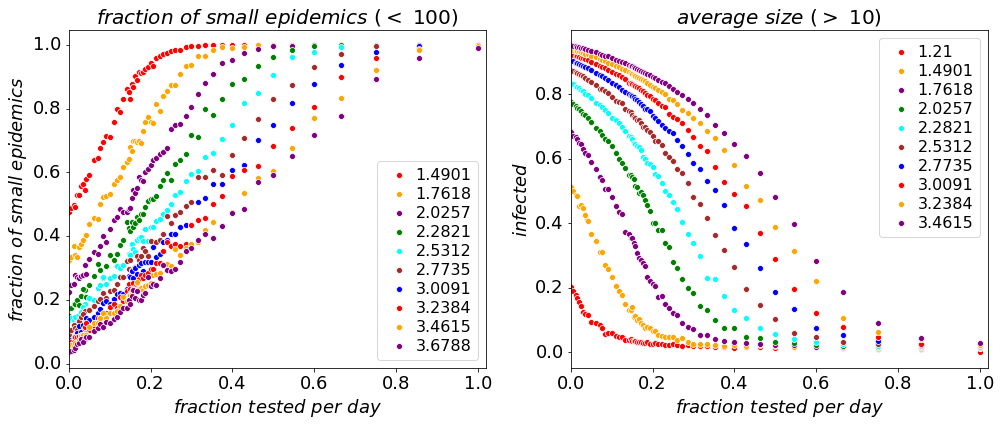

In [18]:
# plots data

import seaborn
from itertools import compress

newsim    = pd.read_csv('different_testing_rates.zip')
colorlist = ['red','orange','purple','green','cyan','brown','blue','red','orange','purple']
R0range   = [1.2100,1.4901, 1.7618, 2.0257, 2.2821, 2.5312,2.7735, 3.0091, 3.2384, 3.4615, 3.6788]
test_interval_range   = list([1000000,1000])+ list(range(496,248,-96)) + list(range(248,124,-48)) + list(range(168,84,-24)) + list(range(84,51,-6))  + list(range(51,42,-3)) + list(range(42,5,-1))


Fig5 = plt.figure(figsize=(14,6))

daily_fraction       = []
max_size             = []
average_size         = []
average_large_size   = []
less_than_100        = []
R0s                  = []
max_size_over_fraction_of_large = []

#test_interval_range = range (42,0,-1)
for R0 in R0range:
    c = newsim['R0'] == R0
    for i in test_interval_range:
        current_column = "interval_"+str(i)+".0"
        #ax = seaborn.scatterplot(newsim[current_column + "_days"], newsim[current_column], alpha = 0.3, label = str(math.trunc(100/i)/100))
        current_sizes       = newsim[current_column][c]
        current_large_sizes = current_sizes[current_sizes > 10]
        average_size.append(statistics.mean(current_sizes)/matrix_size)
        if (len(current_large_sizes) == 0): 
            average_large_size.append(0)
        else:
            average_large_size.append(statistics.mean(current_large_sizes)/matrix_size)
        max_fraction_infected       = max(current_sizes)/matrix_size
        fraction_of_small_epidemics = sum(current_sizes < 100) / number_of_simulations

        max_size.append(max_fraction_infected)
        less_than_100.append(fraction_of_small_epidemics)
        #if (fraction_of_large_epidemics > 0):
        #    max_size_over_fraction_of_large.append(max_fraction_infected / fraction_of_large_epidemics)
        #else:
        #    max_size_over_fraction_of_large.append(0)

        daily_fraction.append(6/i)
        R0s.append(R0)

plt.xlabel("$\itdays$", fontsize = 14)
plt.ylabel("$\itinfected$", fontsize = 14)
#ax.legend(labelspacing=0.25, handletextpad = 0, fontsize = 4, loc = 4)

plt.subplot(122)
plt.xticks(horizontalalignment='center', fontsize = 18)
plt.yticks(verticalalignment='center', fontsize = 18)
i = 0
for R0 in R0range[:-1]:
    print(R0)
    c = np.array(R0s) == R0
    ax = seaborn.scatterplot(list(compress(daily_fraction,c)), list(compress(average_large_size,c)), label = str(R0), color = colorlist[i])
    i += 1
    #ax = seaborn.scatterplot(daily_fraction, average_size, label = "average size")
plt.xlabel("$\itfraction\ tested\ per\ day$", fontsize = 18)
plt.ylabel("$\itinfected$", fontsize = 18)
ax.set_xlim(0,1.02)
ax.set_title("$\itaverage\ size\ (>\ 10)$", fontsize = 20)
ax.legend(labelspacing=0.25, handletextpad = 0, fontsize = 16, loc = 1)


plt.subplot(121)
plt.xticks(horizontalalignment='center', fontsize = 18)
plt.yticks(verticalalignment='center', fontsize = 18)
i = 0
for R0 in R0range[1:]:
    c = np.array(R0s) == R0
    ax = seaborn.scatterplot(list(compress(daily_fraction,c)), list(compress(less_than_100,c)), label = str(R0), color = colorlist[i])
    i += 1
plt.xlabel("$\itfraction\ tested\ per\ day$", fontsize = 18)
plt.ylabel("$\itfraction\ of\ small\ epidemics$", fontsize = 18)
ax.set_xlim(0,1.02)
ax.set_title("$\itfraction\ of\ small\ epidemics\ (<\ 100)$", fontsize = 20)
ax.legend(labelspacing=0.25, handletextpad = 0, fontsize = 16, loc = 4)

plt.tight_layout(pad=1, h_pad=1, w_pad=2, rect=None)
Fig5.savefig("Fig5CD.pdf")
Fig5.savefig("Fig5CD.png", dpi=600)

In [7]:
# Comparing types of test
# sets up social graph and vectors that describe parameters for individuals

start        = time.time()
output_data  = pd.DataFrame()

simulations         = 0
total_simulations   = 0

# sets up social graph
infectious_period               = 14 # half days

matrix_size                     = 10000
average_number_of_contacts      = 20
number_of_contacts              = np.zeros(matrix_size, dtype=np.int32)
count_number_of_incoming_contacts_jit_parallel(social_graph, number_of_contacts)
fraction_of_contacts = np.array(np.divide(number_of_contacts, statistics.mean(number_of_contacts)), dtype=np.float32)

# dictionary for graphs
graphs = {}

# fully connected

graph_type        = "Fully connected"
social_graph      = np.ones(shape=(matrix_size,matrix_size), dtype=np.int8)
#random_matrix     = np.array(np.random.rand(matrix_size,matrix_size), dtype=np.float32)
graphs[graph_type] = np.copy(social_graph)
    
# sets up social graph (Random)
graph_type        = "Random graph"
social_graph      = np.zeros(shape=(matrix_size,matrix_size), dtype=np.int8)
random_graph_diagonal_one_jit_parallel(social_graph, average_number_of_contacts / (matrix_size * 2), 1, 0)
graphs[graph_type] = np.copy(social_graph)

# 50-50 Mix of Barabasi_Albert and Random
graph_type        = "Barabasi Albert : Random 50:50"
social_network    = nx.barabasi_albert_graph(n=matrix_size, m=average_number_of_contacts//4)
social_graph      = np.array(nx.to_numpy_matrix(social_network), dtype = np.int8)
random_graph_diagonal_one_jit_parallel(social_graph, average_number_of_contacts / (matrix_size * 4), 1, 0)
for x in range(matrix_size):
    social_graph[x][x] = 1
graphs[graph_type] = np.copy(social_graph)
    
# Small world
graph_type        = "Watts Strogatz small world"
social_network    = nx.watts_strogatz_graph(n=matrix_size, k=average_number_of_contacts, p=0.2, seed=None)
social_graph      = np.array(nx.to_numpy_matrix(social_network), dtype = np.int8)
for x in range(matrix_size):
    social_graph[x][x] = 1
graphs[graph_type] = np.copy(social_graph)
    
# Barabasi_Albert
graph_type        = "Barabasi Albert"
social_network    = nx.barabasi_albert_graph(n=matrix_size, m=average_number_of_contacts//2)
social_graph      = np.array(nx.to_numpy_matrix(social_network), dtype = np.int8)
for x in range(matrix_size):
    social_graph[x][x] = 1
graphs[graph_type] = np.copy(social_graph)
    
graph_type = graph_type + " population=" + str(matrix_size) + " average contacts=" + str(average_number_of_contacts)

original_graph_type = graph_type

# determines contacts per individual for current graph
contacts                = count_contacts_jit_parallel(social_graph)
contacts_per_individual = contacts / matrix_size

R0                 = 2.35

# sets daily transmission probability based on contacts per individual and R0
daily_transmission_probability = R0 / (contacts_per_individual * infectious_period)
print(contacts, contacts_per_individual, daily_transmission_probability, daily_transmission_probability * contacts_per_individual * infectious_period)




199800 19.98 0.008401258401258401 2.35


In [8]:
# MAIN PROGRAM FOR COMPARING TESTING AND ISOLATION DESIGNS

# sets number of simulations (even number)
start_from_fraction    = 20
number_of_simulations  = matrix_size // start_from_fraction 

memory_vector        = np.zeros(matrix_size, dtype=np.int32)
test_parameters      = np.zeros(10, dtype=np.float32)

output_data          = pd.DataFrame()

running_time         = []
result               = []

test_parameters[0] = 1                         #testing_strategy (1 = random, 2 = all at the same time)
test_parameters[1] = float32(infectious_period)         #test_interval
test_parameters[2] = 0.9                       #test_true_positive 
test_parameters[3] = 0.8                       #isolation_compliance
test_parameters[4] = 0                         #isolate_contacts (tracing efficiency)
test_parameters[5] = 0                         #test time relative to infectious period (0 is all the time)
#test_parameters[5] = infectious_period//2      #test_time
test_parameters[6] = 0                         #fractional_bias_based_on_contact_freq
test_parameters[7] = 0                         #test delay time
test_parameters[8] = 1                         #trace delay time

# counts number of contacts for each individual, and determines fraction of contacts
count_number_of_incoming_contacts_jit_parallel(social_graph, number_of_contacts)
fraction_of_contacts = np.array(np.divide(number_of_contacts, statistics.mean(number_of_contacts)), dtype=np.float32)

parameter_memory = np.copy(test_parameters)

start    = time.time()

# runs simulation for different testing types
# main loop for the simulation (takes in the order of 1 hour to run 500 simulations for a population of 10000 for all the designs)
for simulations in range (number_of_simulations):
      
    test_parameters[2] = 0
    initialize_and_run("No_test", test_parameters, output_data, daily_transmission_probability)
    test_parameters = np.copy(parameter_memory)

    initialize_and_run("Random_test", test_parameters, output_data, daily_transmission_probability)
    test_parameters = np.copy(parameter_memory)
    
    test_parameters[1] = 2
    test_parameters[5] = infectious_period / 2
    test_parameters[2] = 0.7  
    initialize_and_run("Symptom_test", test_parameters, output_data, daily_transmission_probability)
    test_parameters = np.copy(parameter_memory)
    
    test_parameters[6] = 1
    initialize_and_run("Random_test_high_contact", test_parameters, output_data, daily_transmission_probability)
    test_parameters = np.copy(parameter_memory)
    
    test_parameters[0] = 2
    initialize_and_run("Same_day_test", test_parameters, output_data, daily_transmission_probability)
    test_parameters = np.copy(parameter_memory)   
    
    test_parameters[4] = 0.6
    initialize_and_run("Random_test_isolate_contacts", test_parameters, output_data, daily_transmission_probability)
    test_parameters = np.copy(parameter_memory)   
 
    
    test_parameters[1] = 2
    #test_parameters[2] = 1
    test_parameters[5] = 0
    initialize_and_run("Test_before_contacts", test_parameters, output_data, daily_transmission_probability)
    test_parameters = np.copy(parameter_memory)   
    
    test_parameters[0] = 2
    test_parameters[4] = 0.6
    initialize_and_run("Same_day_test_isolate_contacts", test_parameters, output_data, daily_transmission_probability)
    test_parameters = np.copy(parameter_memory)   
    
    test_parameters[4] = 0.6
    test_parameters[6] = 1
    initialize_and_run("Random_test_high_contact_and_isolate", test_parameters, output_data, daily_transmission_probability)
    test_parameters = np.copy(parameter_memory) 
     
    running_time.append(time.time()-start)

# writes data to file
compression_opts = dict(method='zip',
                        archive_name='different_testing_types_2.csv')  
output_data.to_csv('different_testing_types_2.zip', index=False,
          compression=compression_opts)

2.35 No_test 0 1.7447121143341064 (90, 7703)
2.35 Random_test 0 2.5710208415985107 (109, 5908)
2.35 Symptom_test 0 3.5934572219848633 (95, 6991)
2.35 Random_test_high_contact 0 4.416375398635864 (201, 3136)
2.35 Same_day_test 0 5.018707513809204 (98, 4508)
2.35 Random_test_isolate_contacts 0 5.023145914077759 (2, 4)
2.35 Test_before_contacts 0 5.02798867225647 (5, 12)
2.35 Same_day_test_isolate_contacts 0 5.3990864753723145 (108, 1979)
2.35 Random_test_high_contact_and_isolate 0 5.65259575843811 (240, 610)
2.35 No_test 200 778.4053454399109 (122, 7729)
2.35 Random_test 200 779.2451617717743 (133, 5888)
2.35 Symptom_test 200 780.2645432949066 (109, 6992)
2.35 Random_test_high_contact 200 781.0780527591705 (216, 3348)
2.35 Same_day_test 200 781.7091724872589 (156, 4338)
2.35 Random_test_isolate_contacts 200 781.7160902023315 (14, 1)
2.35 Test_before_contacts 200 781.7176978588104 (3, 1)
2.35 Same_day_test_isolate_contacts 200 782.1258962154388 (183, 2068)
2.35 Random_test_high_contact_an

In [9]:
# runs simulation for same day test (with isolation of contacts)
#start_from_fraction    = 10
number_of_simulations   = matrix_size // start_from_fraction

# determines contacts per individual for current graph
contacts                = count_contacts_jit_parallel(social_graph)
contacts_per_individual = contacts / matrix_size

start              = time.time()
output_data        = pd.DataFrame()
total_simulations  = 0

scan_range         = [*range(4), *range(4,12,2)]
test_parameters    = np.copy(parameter_memory)

test_parameters[3]
test_parameters[0] = 2
test_parameters[4] = 0.6

# main loop for the simulation (takes in the order of 1 hour to run 500 simulations for a population of 10000 for all the delays set above)
for simulations in range (number_of_simulations):
    for (test_parameters[7]) in scan_range:      
        initialize_and_run(str(test_parameters[7])+"_day_delay", test_parameters, output_data, daily_transmission_probability)
    test_parameters[2] = 0
    initialize_and_run("no_test", test_parameters, output_data, daily_transmission_probability)
    test_parameters[2] = 0.9
    
compression_opts = dict(method='zip',
                        archive_name='different_delays.csv')  
output_data.to_csv('different_delays.zip', index=False,
          compression=compression_opts)

2.35 0.0_day_delay 0 0.3808321952819824 (113, 1819)
2.35 1.0_day_delay 0 0.8985233306884766 (183, 2350)
2.35 2.0_day_delay 0 1.5448079109191895 (170, 3305)
2.35 3.0_day_delay 0 2.1187057495117188 (115, 3388)
2.35 4.0_day_delay 0 2.739649534225464 (159, 3721)
2.35 6.0_day_delay 0 3.5045950412750244 (146, 4511)
2.35 8.0_day_delay 0 4.254094839096069 (107, 4888)
2.35 10.0_day_delay 0 5.0519092082977295 (117, 5308)
2.35 no_test 0 6.275580167770386 (99, 7705)
2.35 0.0_day_delay 200 1042.9898912906647 (111, 1415)
2.35 1.0_day_delay 200 1042.9968309402466 (15, 3)
2.35 2.0_day_delay 200 1043.001213312149 (14, 1)
2.35 3.0_day_delay 200 1043.6850357055664 (153, 3697)
2.35 4.0_day_delay 200 1044.3782842159271 (172, 3758)
2.35 6.0_day_delay 200 1045.1055126190186 (133, 4430)
2.35 8.0_day_delay 200 1045.8618292808533 (135, 5146)
2.35 10.0_day_delay 200 1046.6833629608154 (121, 5653)
2.35 no_test 200 1047.8876576423645 (118, 7715)
2.35 0.0_day_delay 400 1865.0900993347168 (167, 1993)
2.35 1.0_day_de

In [10]:
# compare concurrency, delay and random test
#start_from_fraction    = 10
number_of_simulations  = matrix_size // start_from_fraction

start              = time.time()
output_data        = pd.DataFrame()
total_simulations  = 0

test_parameters[0] = 1                         #testing_strategy (1 = random, 2 = all at the same time)
test_parameters[1] = float32(infectious_period)         #test_interval
test_parameters[2] = 1                         #test_true_positive 
test_parameters[3] = 1                         #isolation_compliance
test_parameters[4] = 0                         #isolate_contacts (tracing efficiency)
test_parameters[5] = 0                          #test time relative to infectious period (0 is all the time)
#test_parameters[5] = infectious_period//2      #test_time
test_parameters[6] = 0                         #fractional_bias_based_on_contact_freq
test_parameters[7] = 0                         #test delay time
test_parameters[8] = 0                         #trace delay time


cp_range    = [1.0,0.7,0.5]
delay_range = [0,2,4]
test_parameters = np.copy(parameter_memory)

# main loop for the simulation (takes in the order of 2 hours to run 500 simulations for a population of 10000 for all the designs set above)
for simulations in range (number_of_simulations):
    for (test_parameters[2]) in cp_range: 
        for (test_parameters[7]) in delay_range:
            initialize_and_run("random_"+str(test_parameters[2])+"_delay_"+str(test_parameters[7]), test_parameters, output_data, daily_transmission_probability)
            test_parameters[0] = 2 
            initialize_and_run("concurrent_cp_"+str(test_parameters[2])+"_delay_"+str(test_parameters[7]), test_parameters, output_data, daily_transmission_probability)
            test_parameters[0] = 1 
    test_parameters[2] = 0
    initialize_and_run("no_test", test_parameters, output_data, daily_transmission_probability)
    test_parameters[2] = 1

compression_opts = dict(method='zip', archive_name='cp_vs_delay2.csv')  
output_data.to_csv('cp_vs_delay2.zip', index=False, compression=compression_opts)

2.35 random_1.0_delay_0.0 0 0.7831211090087891 (126, 5563)
2.35 concurrent_cp_1.0_delay_0.0 0 1.3076329231262207 (115, 3417)
2.35 random_1.0_delay_2.0 0 2.135016918182373 (96, 5908)
2.35 concurrent_cp_1.0_delay_2.0 0 2.879808187484741 (86, 5632)
2.35 random_1.0_delay_4.0 0 3.7362067699432373 (98, 6312)
2.35 concurrent_cp_1.0_delay_4.0 0 4.641266345977783 (129, 6451)
2.35 random_0.7_delay_0.0 0 5.526754379272461 (118, 6275)
2.35 concurrent_cp_0.7_delay_0.0 0 6.320683717727661 (140, 5874)
2.35 random_0.7_delay_2.0 0 7.24217414855957 (104, 6555)
2.35 concurrent_cp_0.7_delay_2.0 0 8.136715412139893 (109, 6385)
2.35 random_0.7_delay_4.0 0 9.091953992843628 (102, 6645)
2.35 concurrent_cp_0.7_delay_4.0 0 10.072972059249878 (99, 6788)
2.35 random_0.5_delay_0.0 0 11.035678625106812 (120, 6619)
2.35 concurrent_cp_0.5_delay_0.0 0 11.945103883743286 (125, 6484)
2.35 random_0.5_delay_2.0 0 12.951697587966919 (102, 6872)
2.35 concurrent_cp_0.5_delay_2.0 0 13.933974742889404 (114, 6944)
2.35 random_0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part


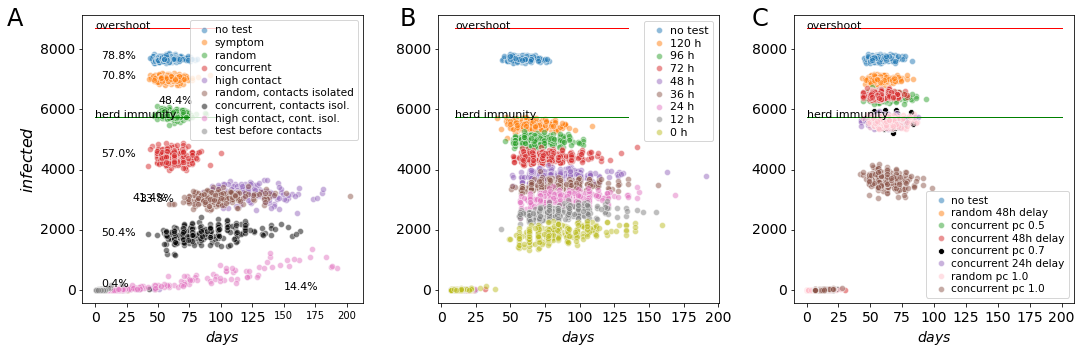

In [11]:
# plots figure

import math
from scipy.special import lambertw
import matplotlib.pyplot as plt
import seaborn
import pandas as pd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from matplotlib import rc

# activate latex text rendering
rc('text', usetex=False)

#@njit
def kaplan_meier(input_vector, output_vector, max_days):
    output_vector[0] = 1
    matrix_size =  np.sum(input_vector >= 0)
    for i in range (1, max_days):
        output_vector[i] = np.sum(input_vector > i) / matrix_size

def plot_percent(col):
     return np.percentile(col, 70), str(100 * sum(col > 100)/len(col))[:4] + '%'     #str(np.mean(col)*100/matrix_size)[:4] + '%'
        
R0 = 2.35
matrix_size = 10000
number_of_simulations = 1000

d = pd.read_csv('different_testing_types_2.zip')

z       = float(1 + lambertw(-math.exp(-R0)*R0, 0)/R0)

predicted_infected = z * matrix_size
herd_immunity      = ((R0 - 1) / R0) * matrix_size

Fig4 = plt.figure(figsize=(15,5))

#plt.subplot(121)
#ax = seaborn.boxplot(d.iloc[:, [1]])

plt.subplot(131)
ax = seaborn.scatterplot(d['No_test_days']/2, d['No_test'], label = "no test", alpha = 0.5)
plt.text(5, *plot_percent(d['No_test']), fontsize=11)
ax = seaborn.scatterplot(d['Symptom_test_days']/2, d['Symptom_test'], label = "symptom", alpha = 0.5)
plt.text(5, *plot_percent(d['Symptom_test']), fontsize=11)
ax = seaborn.scatterplot(d['Random_test_days']/2, d['Random_test'], label = "random", alpha = 0.5)
plt.text(50,plot_percent(d['Random_test'])[0]+400, plot_percent(d['Random_test'])[1], fontsize=11)
ax = seaborn.scatterplot(d['Same_day_test_days']/2, d['Same_day_test'], label = "concurrent", alpha = 0.5)
plt.text(5, *plot_percent(d['Same_day_test']), fontsize=11)
ax = seaborn.scatterplot(d['Random_test_high_contact_days']/2, d['Random_test_high_contact'], label = "high contact", alpha = 0.5)
plt.text(35, *plot_percent(d['Random_test_high_contact']), fontsize=11)
ax = seaborn.scatterplot(d['Random_test_isolate_contacts_days']/2, d['Random_test_isolate_contacts'], label = "random, contacts isolated", alpha = 0.5)
plt.text(30, *plot_percent(d['Random_test_isolate_contacts']), fontsize=11)
ax = seaborn.scatterplot(d['Same_day_test_isolate_contacts_days']/2, d['Same_day_test_isolate_contacts'], label = "concurrent, contacts isol.", color = "black", alpha = 0.5)
plt.text(5, *plot_percent(d['Same_day_test_isolate_contacts']), fontsize=11)
ax = seaborn.scatterplot(d['Random_test_high_contact_and_isolate_days']/2, d['Random_test_high_contact_and_isolate'], label = "high contact, cont. isol.", alpha = 0.5)
plt.text(150, *plot_percent(d['Random_test_high_contact_and_isolate']), fontsize=11)
ax = seaborn.scatterplot(d['Test_before_contacts_days']/2, d['Test_before_contacts'], label = "test before contacts", alpha = 0.5)
plt.text(5, plot_percent(d['Test_before_contacts'])[0]+125, plot_percent(d['Test_before_contacts'])[1], fontsize=11)

plt.xticks(horizontalalignment='center', fontsize = 14)
plt.yticks(verticalalignment='center', fontsize = 14)
plt.xlabel("$\itdays$", fontsize = 14)
plt.ylabel("$\itinfected$", fontsize = 16)
plt.text(0, predicted_infected+10, "overshoot", fontsize=11)
plt.plot([0,95], [predicted_infected,predicted_infected], linewidth=1, linestyle= "solid", color="red")
plt.text(0, herd_immunity+10, "herd immunity", fontsize=11)
plt.plot([0,95], [herd_immunity,herd_immunity], linewidth=1, linestyle= "solid", color="green")
ax.legend(labelspacing=0.25, handletextpad = 0, fontsize = 10.5, loc = 1)
plt.text(-70, 8800, "A", fontsize = 24)


d = pd.read_csv('different_delays.zip')
scan_range = [*range(4), *range(4,12,2)][::-1]
plt.subplot(132)
plt.xticks(horizontalalignment='center', fontsize = 14)
plt.yticks(verticalalignment='center', fontsize = 14)
plt.text(10, predicted_infected+10, "overshoot", fontsize=11)
plt.plot([10,135], [predicted_infected,predicted_infected], linewidth=1, linestyle= "solid", color="red")
plt.text(10, herd_immunity+10, "herd immunity", fontsize=11)
plt.plot([10,135], [herd_immunity,herd_immunity], linewidth=1, linestyle= "solid", color="green")
ax = seaborn.scatterplot(d["no_test_days"]/2, d["no_test"], label = "no test", alpha = 0.5)
for x in scan_range:
    ax = seaborn.scatterplot(d[str(x)+".0_day_delay_days"]/2, d[str(x)+".0_day_delay"], label = str(x*12)+ " h", alpha = 0.5)
plt.xlabel("$\itdays$", fontsize = 14)
plt.ylabel("", fontsize = 14)
plt.text(-30, 8800, "B", fontsize = 24)
ax.legend(labelspacing=0.25, handletextpad = 0, fontsize = 11, loc = 1)
#plt.suptitle("Figure 1", y = 1, x = 0, fontsize = 12)


d = pd.read_csv('cp_vs_delay2.zip')
plt.subplot(133)
plt.xticks(horizontalalignment='center', fontsize = 14)
plt.yticks(verticalalignment='center', fontsize = 14)

ax = seaborn.scatterplot(d['no_test_days']/2, d['no_test'], label = "no test", alpha = 0.5)
ax = seaborn.scatterplot(d['random_0.5_delay_4.0_days']/2, d['random_0.5_delay_4.0'], label = "random 48h delay", alpha = 0.5)
ax = seaborn.scatterplot(d['concurrent_cp_0.5_delay_0.0_days']/2, d['concurrent_cp_0.5_delay_0.0'], label = "concurrent pc 0.5", alpha = 0.5)
ax = seaborn.scatterplot(d['concurrent_cp_1.0_delay_4.0_days']/2, d['concurrent_cp_1.0_delay_4.0'], label = "concurrent 48h delay", alpha = 0.5)
ax = seaborn.scatterplot(d['concurrent_cp_0.7_delay_0.0_days']/2, d['concurrent_cp_0.7_delay_0.0'], label = "concurrent pc 0.7", color = "black", alpha = 1)
ax = seaborn.scatterplot(d['concurrent_cp_1.0_delay_2.0_days']/2, d['concurrent_cp_1.0_delay_2.0'], label = "concurrent 24h delay", alpha = 0.5)
ax = seaborn.scatterplot(d['random_1.0_delay_0.0_days']/2, d['random_1.0_delay_0.0'], label = "random pc 1.0", color = "pink", alpha = 0.5)
ax = seaborn.scatterplot(d['concurrent_cp_1.0_delay_0.0_days']/2, d['concurrent_cp_1.0_delay_0.0'], label = "concurrent pc 1.0", alpha = 0.5)

plt.text(0, predicted_infected+10, "overshoot", fontsize=11)
plt.plot([0,200], [predicted_infected,predicted_infected], linewidth=1, linestyle= "solid", color="red")
plt.text(0, herd_immunity+10, "herd immunity", fontsize=11)
plt.plot([0,200], [herd_immunity,herd_immunity], linewidth=1, linestyle= "solid", color="green")
plt.xlabel("$\itdays$", fontsize = 14)
plt.ylabel("", fontsize = 14)
plt.text(-43, 8800, "C", fontsize = 24)
ax.legend(labelspacing=0.25, handletextpad = 0, fontsize = 10.5, loc = 4)

plt.tight_layout(pad=1, h_pad=1, w_pad=2, rect=None)
Fig4.savefig("Fig4_Barabasi_Albert.pdf")
Fig4.savefig("Fig4_Barabasi_Albert.png", dpi=600)